# Mortgage calculator

This notebook contains some Python code to analyze the two main mortgage types in the Netherlands:
- **Annuity mortgage**: Monthly sum of principal and interest stays constant over time. 
- **Linear mortgage**: Monthly principal stays constant over time.

## Import prerequisites:

In [1]:
from datetime import date
import matplotlib.pyplot as plt
import numpy_financial as npf
import pandas as pd

%load_ext watermark
%watermark -a "Author: gmalim" 
print("")
%watermark -u -n
print("")
%watermark -v -p matplotlib,numpy,pandas
print("")
%watermark -m

Author: gmalim

last updated: Sun Oct 18 2020

CPython 3.6.5
IPython 7.14.0

matplotlib 3.3.2
numpy 1.19.2
pandas 1.1.3

compiler   : GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 2
interpreter: 64bit


## Methods

Define annuity and linear mortgage calculation methods:

In [2]:
def create_dataframe(n_years,
                     n_payments_per_year,
                     start_date):

    rng = pd.date_range(start_date, periods=n_years*n_payments_per_year, freq='MS')
    rng.name = "Payment Date"
    column_names = ['Principal', 'Interest', 'Payment', 'Ending Balance']
    df = pd.DataFrame(index=rng, columns=column_names, dtype='float')
    df.reset_index(inplace=True)
    df.index += 1
    df.index.name = "Period"

    return df

In [3]:
def create_annuity_mortage_data(mortgage_value,
                                interest_rate,
                                n_years,
                                n_payments_per_year,
                                df):
    
    interest_rate_per_period = interest_rate / n_payments_per_year
    n_payments = n_years * n_payments_per_year
    
    df["Principal"] = -1 * npf.ppmt(interest_rate_per_period, df.index, n_payments, mortgage_value)
    df["Interest"] = -1 * npf.ipmt(interest_rate_per_period, df.index, n_payments, mortgage_value)
    df["Payment"] = -1 * npf.pmt(interest_rate_per_period, n_payments, mortgage_value)
    
    df["Ending Balance"] = 0
    df.loc[1, "Ending Balance"] = mortgage_value - df.loc[1, "Principal"]
    for period in range(2, len(df)+1):
        previous_balance = df.loc[period-1, 'Ending Balance']
        principal_paid = df.loc[period, 'Principal']
        df.loc[period, 'Ending Balance'] = previous_balance - principal_paid
    
    return

In [4]:
def create_linear_mortage_data(mortgage_value,
                               interest_rate,
                               n_years,
                               n_payments_per_year,
                               df):
    
    principal_per_period = mortgage_value / n_years / n_payments_per_year
    
    df["Principal"] = principal_per_period

    df["Interest"] = 0
    df["Payment"] = 0
    df["Ending Balance"] = 0
    df.loc[1, "Interest"] = interest_rate / n_payments_per_year * mortgage_value
    df.loc[1, "Payment"] = principal_per_period + df.loc[1, "Interest"]
    df.loc[1, "Ending Balance"] = mortgage_value - df.loc[1, "Principal"]
    for period in range(2, len(df)+1):
        previous_balance = df.loc[period-1, 'Ending Balance']
        interest = interest_rate / n_payments_per_year * previous_balance
        payment = principal_per_period + interest
        df.loc[period, 'Interest'] = interest
        df.loc[period, 'Payment'] = payment
        df.loc[period, 'Ending Balance'] = previous_balance - principal_per_period
    
    return

## User input

Choose mortgage value, annual interest rate and duration of the mortgage:

In [5]:
mortgage_value = 600000 # mortgage value in €
interest_rate = 0.02 # annual interest rate
n_years = 30 # number of mortgage years
n_payments_per_year = 12 # number of payments per year
start_date = (date(2021, 1, 1)) # start date

## Calculate mortgages

In [6]:
df_annuity = create_dataframe(n_years, n_payments_per_year, start_date)

create_annuity_mortage_data(mortgage_value, interest_rate, n_years, n_payments_per_year, df_annuity)

print(df_annuity.round(2))

       Payment Date  Principal  Interest  Payment  Ending Balance
Period                                                           
1        2021-01-01    1217.72   1000.00  2217.72       598782.28
2        2021-02-01    1219.75    997.97  2217.72       597562.54
3        2021-03-01    1221.78    995.94  2217.72       596340.76
4        2021-04-01    1223.82    993.90  2217.72       595116.94
5        2021-05-01    1225.86    991.86  2217.72       593891.09
...             ...        ...       ...      ...             ...
356      2050-08-01    2199.33     18.39  2217.72         8834.03
357      2050-09-01    2202.99     14.72  2217.72         6631.03
358      2050-10-01    2206.67     11.05  2217.72         4424.37
359      2050-11-01    2210.34      7.37  2217.72         2214.03
360      2050-12-01    2214.03      3.69  2217.72            0.00

[360 rows x 5 columns]


In [7]:
df_linear = create_dataframe(n_years, n_payments_per_year, start_date)

create_linear_mortage_data(mortgage_value, interest_rate, n_years, n_payments_per_year, df_linear)

print(df_linear.round(2))

       Payment Date  Principal  Interest  Payment  Ending Balance
Period                                                           
1        2021-01-01    1666.67   1000.00  2666.67       598333.33
2        2021-02-01    1666.67    997.22  2663.89       596666.67
3        2021-03-01    1666.67    994.44  2661.11       595000.00
4        2021-04-01    1666.67    991.67  2658.33       593333.33
5        2021-05-01    1666.67    988.89  2655.56       591666.67
...             ...        ...       ...      ...             ...
356      2050-08-01    1666.67     13.89  1680.56         6666.67
357      2050-09-01    1666.67     11.11  1677.78         5000.00
358      2050-10-01    1666.67      8.33  1675.00         3333.33
359      2050-11-01    1666.67      5.56  1672.22         1666.67
360      2050-12-01    1666.67      2.78  1669.44           -0.00

[360 rows x 5 columns]


## Visualize mortgages

In [8]:
def make_plot(df):
        
    plt.figure(figsize=(20,14))
    
    # # Select only the first period of every year for visualization purposes:
    # df = df.iloc[::n_payments_per_year, :]
    # df[['Principal', 'Interest']].plot.bar(stacked=True)

    # df[['Payment', 'Principal', 'Interest']].plot(kind='area', stacked=False, alpha=0.2)
    df[['Payment', 'Principal', 'Interest']].plot()

    margin_factor = 1.15
    y_max = margin_factor * ((mortgage_value / n_years) + (interest_rate * mortgage_value)) / n_payments_per_year
    plt.ylim(0, y_max)
    plt.xlim(0, n_years * n_payments_per_year)
    plt.grid(True)
    plt.xlabel("Payment number")
    plt.ylabel("Amount (€)")
    plt.title("Mortgage = € {}, Rate = {:.1f} %, Duration = {} years" \
              .format(mortgage_value, interest_rate * 100, n_years))
    
    total_interest = df["Interest"].sum()
    text_str = "Total interest: € {:.2f} (i.e. {:.1f} % of mortgage)" \
               .format(total_interest, total_interest / mortgage_value * 100)
    plt.text(10, 100, text_str, fontsize=9)
    
    return

<Figure size 1440x1008 with 0 Axes>

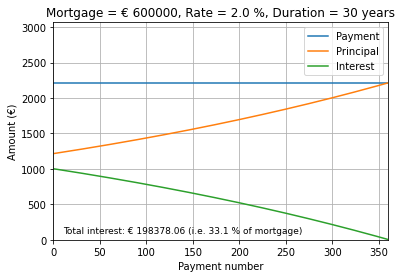

In [9]:
make_plot(df_annuity)

<Figure size 1440x1008 with 0 Axes>

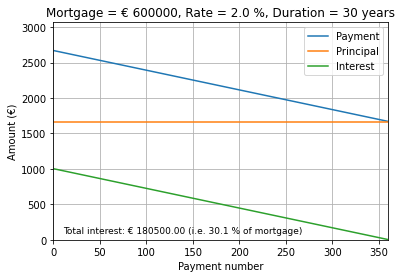

In [10]:
make_plot(df_linear)